# Python segmentation integration test

Make some test data for segmentation and test algorithm implementation.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

np.random.seed(12345)

# Set up constants

In [41]:
# duration stuff

T = 50  # total duration (in s)
dt = 0.05  # bin size (in s)
Nt = int(np.ceil(T / dt))

mu = 0.5  # mean state duration (in s)
sig = 0.05  # standard deviation of state duration (in s)

In [42]:
# rates
lam = 10.  # baseline rate (Hz)
nu = 5.  # rate multiplier (Hz)

# Make some intervals

In [43]:
durations = mu + sig * np.random.randn(Nt)
changepoints = np.cumsum(durations)
maxind = np.argwhere(changepoints < T)[-1][-1]
changepoints = changepoints[:maxind]

In [44]:
taxis = np.arange(dt, T, dt)
states = np.zeros(Nt)
rates = lam * np.ones(Nt)

In [45]:
for idx in xrange(1, len(changepoints) - 1, 2):
    in_state_1 = (changepoints[idx] < taxis) & (taxis < changepoints[idx + 1])
    states[in_state_1] = 1
    rates[in_state_1] = nu * lam

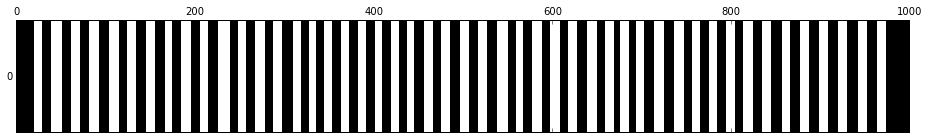

In [46]:
plt.matshow(states[np.newaxis, :], cmap="gray", aspect="auto");

# Make counts

In [48]:
urates, inds = np.unique(rates, return_inverse=True)


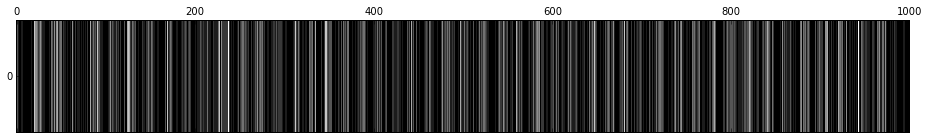

In [56]:
counts = stats.poisson.rvs(rates * dt)

plt.matshow(counts[np.newaxis, :], cmap="gray", aspect="auto");